# About the data

## The Toxicity Dataset
Provided by Surge AI, the world's most powerful NLP data labeling platform and workforce.\
This is a dataset contains 500 toxic and 500 non-toxic comments from a variety of popular social media platforms. The toxicity text are labled with "toxic" or "not toxic", we will utilize the labeled data to train our NLP model with John Snow Lab for toxic behavior detection.

Source: https://github.com/surge-ai/toxicity/blob/main/toxicity_en.csv


## Dota 2 Dataset 
Dota 2 is a multiplayer online battle arena (MOBA) video game in which two teams of five players compete to destroy a large structure defended by the opposing team known as the "Ancient" whilst defending their own. 

This dataset is origined from Kaggle contest - Dota 2 Matches, containing 50000 ranked ladder matches from the Dota 2 data dump created by Opendota. We would using this dataset to demostrate Databricks Delta Lake storage and apply our NLP classification model to predict 144k game chat toxicity classification. 

Source: https://www.kaggle.com/datasets/devinanzelmo/dota-2-matches

## Environment Configuration

To run this notebook, make sure the cluster supports Spark NLP. We are using below config version in the cluster (as for 2023.12)

- **Databrick Runtime Version:** 14.2 ML (includes Apache Spark 3.5.0, Scala 2.12)

- **Additional Spark Config:** \
  spark.kryoserializer.buffer.max 2000M\
  spark.serializer org.apache.spark.serializer.KryoSerializer

- **Install Libraries:** \
  PyPi: spark-nlp==5.1.4 \
  Maven Coordinates: com.johnsnowlabs.nlp:spark-nlp_2.12:5.1.4

In [0]:
import sparknlp

from sparknlp.base import *
from sparknlp.annotator import *
from pyspark.ml import Pipeline
import pandas as pd
import os

spark = sparknlp.start(gpu = True)# for GPU training >> sparknlp.start(gpu = True)

print("Spark NLP version", sparknlp.version())
print("Apache Spark version:", spark.version)

spark

Spark NLP version 5.1.4
Apache Spark version: 3.5.0


## Load Surge AI Toxicity Data


In [0]:
!wget https://raw.githubusercontent.com/surge-ai/toxicity/main/toxicity_en.csv

--2023-11-30 23:58:53--  https://raw.githubusercontent.com/surge-ai/toxicity/main/toxicity_en.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 147594 (144K) [text/plain]
Saving to: ‘toxicity_en.csv.1’

toxicity_en.csv.1   100%[===================>] 144.13K  --.-KB/s    in 0.01s   

2023-11-30 23:58:54 (12.4 MB/s) - ‘toxicity_en.csv.1’ saved [147594/147594]



In [0]:
!ls -l toxicity_en.csv

-rwxrwxrwx 1 root root 147594 Nov 27 03:43 toxicity_en.csv


In [0]:
!head toxicity_en.csv


"Elon Musk is a piece of shit, greedy capitalist who exploits workers, and offers nothing of real benefit to the world.
 All he’s done is make a name for himself on the backs of other people, using dirty money from his family’s emerald mine they acquired during apartheid.
 I don’t care that he’s autistic. He thinks we should be cured with his company’s AI chip. 





"WHY IN THE HELL


In [0]:
from pyspark.sql.types import StructType, StructField, StringType, IntegerType
from pyspark.sql.functions import col, when

# Define the schema
schema = StructType([
    StructField("text", StringType(), True),
    StructField("is_toxic", StringType(), True)  # Initially read as string to apply the transformation below
])

In [0]:
data = spark.read.csv("file:/Workspace/Group 13/toxicity_en.csv", schema=schema, header=True)

In [0]:
data = data.withColumn("is_toxic", when(col("is_toxic") == "Toxic", 1).otherwise(0))
data = data.withColumn("is_toxic", col("is_toxic").cast(IntegerType()))

In [0]:
data.show(5)

+--------------------+--------+
|                text|is_toxic|
+--------------------+--------+
|Elon Musk is a pi...|       0|
| All he’s done is...|       0|
| I don’t care tha...|       0|
| He is not a repr...|       1|
|The senile credit...|       1|
+--------------------+--------+
only showing top 5 rows



In [0]:
train_df, test_df = data.randomSplit([0.7, 0.3], seed=42)

In [0]:
train_df.count()

900

In [0]:
display(train_df.limit(10).filter((col('is_toxic')) == 1))

text,is_toxic
"BLAME OBAMA! IMPEACH OBAMA! REMOVE OBAMA! CRIMINALLY PROSECUTE OBAMA! IMPEACH! IMPEACH! IMPEACH! IMPEACH! IMPEACH! IMPEACH! IMPEACH! IMPEACH!""",1
"#BitchyMitchy""",1
"#LibtardLogic #wakeup #thinkforyourself #SilentNoMore #myvoicematters #silentmajority #DoNotComply #DONOTCONSENT #IDONOTCONSENT""",1
"#TheFecalTouch""",1
"#fuckdems #trump #fuckliberals #america #news #fucksocialism #fuckfeminism #fuckfeminists #donaldtrump #benshaprio #tedcruz #progun #americanpride #american #americapride #foxnews #fucktheleft #prolife #cnn #memes #politics #politicalmemes #msnbc #feminist #lgbt #fuckgays #hellyeah #fuckhilary #fuckpeta""",1


# Build NLP Pipeline -- Deep Learning Classifer with Word Embeddings and Text Preprocessing

1. Document Assembler: This is the first stage where raw text is converted to a structured format for NLP task.
2. Tokenizer: Takes the output from the Document Assembler and breaks the text into individual tokens and words

3. Normalizer: Following the tokenizer, the normalizer standardizes the tokens by removing the punctuation and convert the characters to lower cases (depend on configuration)

4. StopWords Cleaner: Removes common words (such as "and", "the"...) that carry little meaning.

5. Lemmatizer: Process the cleaned tockens to reduce to their base or root forms, here, we are using lemma_antbnc pretained model.

6. Word Embeddings(GloVe): We use GloVe (Global Vectors for Word Representation) model to  take the lemmatized tokens and converts them into numeric vector representations (embeddings), which capture semantic meaning of words.

7. Sentence Embeddings: Aggregate the word embeddings and form sentence-level embeddings, the method of aggregation is defined by "pooling strategy" and we set it as "average".

8. ClassifiedDL: For the last step, we used a deep learning classifier to perform the classification task to classify whether the text is toxic or not, using epoch=3 and output logs enabled"

In [0]:
import sparknlp
from sparknlp.annotator import *
from sparknlp.common import *
from sparknlp.base import *
from pyspark.ml import Pipeline
from pyspark.mllib.evaluation import MultilabelMetrics
from pyspark.sql.functions import lit,when,col,array,array_contains,array_remove,regexp_replace,size,when
from pyspark.sql.types import ArrayType,DoubleType,StringType
from pyspark.ml.evaluation import MultilabelClassificationEvaluator
import mlflow
import mlflow.spark
from mlflow.tracking import MlflowClient
from sparknlp.base import DocumentAssembler
from sparknlp.annotator import UniversalSentenceEncoder
import sparknlp
from sparknlp.base import DocumentAssembler, Finisher
from sparknlp.annotator import UniversalSentenceEncoder
from pyspark.ml import Pipeline

In [0]:
document_assembler = DocumentAssembler() \
    .setInputCol("text") \
    .setOutputCol("document")

tokenizer = Tokenizer() \
    .setInputCols(["document"]) \
    .setOutputCol("token")

normalizer = Normalizer() \
    .setInputCols(["token"]) \
    .setOutputCol("normalized")

stopwords_cleaner = StopWordsCleaner()\
    .setInputCols("normalized")\
    .setOutputCol("cleanTokens")\
    .setCaseSensitive(False)

lemma = LemmatizerModel.pretrained('lemma_antbnc') \
    .setInputCols(["cleanTokens"]) \
    .setOutputCol("lemma")

lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]


In [0]:
glove_embeddings = WordEmbeddingsModel().pretrained() \
    .setInputCols(["document",'lemma'])\
    .setOutputCol("embeddings")\
    .setCaseSensitive(False)

embeddingsSentence = SentenceEmbeddings() \
    .setInputCols(["document", "embeddings"]) \
    .setOutputCol("sentence_embeddings") \
    .setPoolingStrategy("AVERAGE")

classsifierdl = ClassifierDLApproach()\
    .setInputCols(["sentence_embeddings"])\
    .setOutputCol("class")\
    .setLabelColumn("is_toxic")\
    .setMaxEpochs(3)\
    .setEnableOutputLogs(True)

glove_100d download started this may take some time.
Approximate size to download 145.3 MB
[OK!]


In [0]:
clf_pipeline = Pipeline(
    stages=[
        document_assembler,
        tokenizer,
        normalizer,
        stopwords_cleaner,
        lemma,
        glove_embeddings,
        embeddingsSentence,
        classsifierdl])

In [0]:
clf_pipelineModel = clf_pipeline.fit(train_df)

In [0]:
preds = clf_pipelineModel.transform(test_df)

In [0]:
preds_df = preds.select('text','is_toxic','class.result').toPandas()
preds_df['result'] = preds_df['result'].apply(lambda x : x[0])

In [0]:
from sklearn.metrics import classification_report, accuracy_score
preds_df['result'] = preds_df['result'].astype(int)
accuracy = accuracy_score(preds_df['is_toxic'], preds_df['result'])
print (classification_report(preds_df['is_toxic'], preds_df['result']))
print(f"Accuracy Score: {accuracy}")

              precision    recall  f1-score   support

           0       0.89      0.63      0.74       208
           1       0.55      0.84      0.66       109

    accuracy                           0.71       317
   macro avg       0.72      0.74      0.70       317
weighted avg       0.77      0.71      0.71       317

Accuracy Score: 0.7066246056782335



# Ingest Dota 2 Gaming Data Into Delta Lake
Here, we create a database for Dota2 tables to reside in, and we will write the data out in Delta format so that the tables could be easily access and query.

- Delta Lake is an open-source storage framework that enables building a Lakehouse architecture with compute engines including Spark, PrestoDB, Flink, Trino, and Hive.



- Lakehouse Architecture: Data lakehouse is a new, open data management architecture that combines the flexibility, cost-efficiency, and scale of data lakes with the data management and ACID transactions of data warehouses.



- Some features of Delta Lake:
    - ACID Transactions: Ensure data integrity and read consistence.
    - Time Travel: Access/revert to earlier versions of data for audits,rollbacks, or reproduce.
    - Scalable Metadata: Handle petabyte-scale tables in billions of partitions and files with ease.
   

Source https://delta.io/

## Create Dota 2 Database

In [0]:
%sql
DROP DATABASE IF EXISTS dota2 CASCADE;
CREATE DATABASE IF NOT EXISTS dota2;

## Load Dota 2 data into Delta table for analysis
Here, we load player, match, matchoutcomes, and chat data for demostration.\
We move the files to object storage and load the data into Delta tables, userscan check the dota2 database with 4 tables under Databricks data tab.

In [0]:
#player data
players_df = spark.read.csv("file:/Workspace/Users/hsu00161@umn.edu/players.csv", header=True,escape='"',multiLine=True)
players_df.write.format("delta").saveAsTable(f"dota2.players", overwrite=False)
dbutils.fs.mv("file:/Workspace/Users/hsu00161@umn.edu/players.csv", f"dbfs:/tmp/players.csv")

True

In [0]:
#match data
match_df = spark.read.csv("file:/Workspace/Users/hsu00161@umn.edu/match.csv", header=True,escape='"',multiLine=True)
match_df.write.format("delta").saveAsTable(f"dota2.match", overwrite=False)
dbutils.fs.mv("file:/Workspace/Users/hsu00161@umn.edu/match.csv", f"dbfs:/tmp/match.csv")

True

In [0]:
#matchoutcomes data
matchoutc_df = spark.read.csv("file:/Workspace/Users/hsu00161@umn.edu/match_outcomes.csv", header=True,escape='"',multiLine=True)
matchoutc_df.write.format("delta").saveAsTable(f"dota2.matchoutc", overwrite=False)
dbutils.fs.mv("file:/Workspace/Users/hsu00161@umn.edu/match_outcomes.csv", f"dbfs:/tmp/matchoutcomes.csv")

True

In [0]:
#chat data
chat_df = spark.read.csv("file:/Workspace/Users/hsu00161@umn.edu/chat.csv", header=True,escape='"',multiLine=True)
chat_df.write.format("delta").saveAsTable(f"dota2.chat", overwrite=False)
dbutils.fs.mv("file:/Workspace/Users/hsu00161@umn.edu/chat.csv", f"dbfs:/tmp/chat.csv")

True

In [0]:
%sql 
select * from dota2.players limit 5

match_id,account_id,hero_id,player_slot,gold,gold_spent,gold_per_min,xp_per_min,kills,deaths,assists,denies,last_hits,stuns,hero_damage,hero_healing,tower_damage,item_0,item_1,item_2,item_3,item_4,item_5,level,leaver_status,xp_hero,xp_creep,xp_roshan,xp_other,gold_other,gold_death,gold_buyback,gold_abandon,gold_sell,gold_destroying_structure,gold_killing_heros,gold_killing_creeps,gold_killing_roshan,gold_killing_couriers,unit_order_none,unit_order_move_to_position,unit_order_move_to_target,unit_order_attack_move,unit_order_attack_target,unit_order_cast_position,unit_order_cast_target,unit_order_cast_target_tree,unit_order_cast_no_target,unit_order_cast_toggle,unit_order_hold_position,unit_order_train_ability,unit_order_drop_item,unit_order_give_item,unit_order_pickup_item,unit_order_pickup_rune,unit_order_purchase_item,unit_order_sell_item,unit_order_disassemble_item,unit_order_move_item,unit_order_cast_toggle_auto,unit_order_stop,unit_order_taunt,unit_order_buyback,unit_order_glyph,unit_order_eject_item_from_stash,unit_order_cast_rune,unit_order_ping_ability,unit_order_move_to_direction,unit_order_patrol,unit_order_vector_target_position,unit_order_radar,unit_order_set_item_combine_lock,unit_order_continue
0,0,86,0,3261,10960,347,362,9,3,18,1,30,76.7356,8690,218,143,180,37,73,56,108,0,16,0,8840.0,5440.0,null,83.0,50.0,-957.0,null,null,212.0,3120.0,5145.0,1087.0,400.0,null,null,4070.0,1.0,25.0,416.0,51.0,144.0,3.0,71.0,null,188.0,16.0,null,null,null,2.0,35.0,2.0,null,11.0,null,null,null,null,null,null,null,6.0,null,null,null,null,null,null
0,1,51,1,2954,17760,494,659,13,3,18,9,109,87.4164,23747,0,423,46,63,119,102,24,108,22,0,14331.0,8440.0,2683.0,671.0,395.0,-1137.0,null,null,1650.0,3299.0,6676.0,4317.0,937.0,null,null,5894.0,214.0,165.0,1031.0,98.0,39.0,4.0,439.0,null,346.0,22.0,null,null,12.0,52.0,30.0,4.0,null,21.0,null,null,null,null,null,null,null,14.0,null,null,null,null,null,null
0,0,83,2,110,12195,350,385,0,4,15,1,58,None,4217,1595,399,48,60,59,108,65,0,17,0,6692.0,8112.0,null,453.0,259.0,-1436.0,-1015.0,null,null,3142.0,2418.0,3697.0,400.0,null,null,7053.0,3.0,132.0,645.0,36.0,160.0,20.0,373.0,null,643.0,17.0,5.0,null,7.0,8.0,28.0,null,1.0,18.0,null,null,null,1.0,null,null,null,17.0,null,null,null,null,null,null
0,2,11,3,1179,22505,599,605,8,4,19,6,271,None,14832,2714,6055,63,147,154,164,79,160,21,0,8583.0,14230.0,894.0,293.0,100.0,-2156.0,null,null,938.0,4714.0,4104.0,10432.0,400.0,null,null,4712.0,133.0,163.0,690.0,9.0,15.0,7.0,406.0,null,150.0,21.0,null,null,1.0,9.0,45.0,7.0,null,14.0,null,null,null,null,1.0,null,null,13.0,null,null,null,null,null,null
0,3,67,4,3307,23825,613,762,20,3,17,13,245,None,33740,243,1833,114,92,147,0,137,63,24,0,15814.0,14325.0,null,62.0,null,-1437.0,-1056.0,null,4194.0,3217.0,7467.0,9220.0,400.0,null,null,3853.0,7.0,7.0,1173.0,31.0,84.0,8.0,198.0,null,111.0,23.0,1.0,null,null,2.0,44.0,6.0,null,13.0,null,null,null,1.0,3.0,null,null,23.0,null,null,null,null,null,null


In [0]:
%sql
select * from dota2.chat limit 5

match_id,key,slot,time,unit
0,force it,6,-8,6k Slayer
0,space created,1,5,Monkey
0,hah,1,6,Monkey
0,ez 500,6,9,6k Slayer
0,mvp ulti,4,934,Kira


In [0]:
%sql
select * from dota2.matchoutc limit 5

match_id,account_id_0,account_id_1,account_id_2,account_id_3,account_id_4,start_time,parser_version,win,rad
1636204962,34549,0,0,-51743434,-120875154,1437014585,12,1,0
1636204962,0,61598,138825,0,207232,1437014585,12,0,1
1636322679,0,-44943233,-240360907,19599,0,1437019968,12,0,0
1636322679,-97530201,0,0,0,-116349387,1437019968,12,1,1
1637385965,0,0,0,104738,0,1437052551,12,1,0


In [0]:
%sql
select * from dota2.match limit 5

match_id,start_time,duration,tower_status_radiant,tower_status_dire,barracks_status_dire,barracks_status_radiant,first_blood_time,game_mode,radiant_win,negative_votes,positive_votes,cluster
0,1446750112,2375,1982,4,3,63,1,22,True,0,1,155
1,1446753078,2582,0,1846,63,0,221,22,False,0,2,154
2,1446764586,2716,256,1972,63,48,190,22,False,0,0,132
3,1446765723,3085,4,1924,51,3,40,22,False,0,0,191
4,1446796385,1887,2047,0,0,63,58,22,True,0,0,156


## Exploration
We can perform sql query with our delta database, here, we demostrate the query to check the message count per account.

In [0]:
%sql
SELECT  
account_id,
count(key) `# of messages`
FROM dota2.chat
JOIN dota2.players
ON dota2.chat.match_id = dota2.players.match_id
AND dota2.chat.slot = dota2.players.player_slot
GROUP BY account_id
ORDER BY count(key) desc
LIMIT 10;

account_id,# of messages
0,261181
2962,820
20197,382
9149,297
46420,296
52081,264
34471,248
5747,242
30846,238
2276,233


## Query the data for toxicity chat detection

In [0]:
# SQL query to select match_id and key
query = """
SELECT match_id, key
FROM dota2.chat
"""

# Creating a new DataFrame with the result of the SQL query
new_df = spark.sql(query)

# Rename the 'key' column to 'text'
new_df = new_df.withColumnRenamed("key", "text")

# Show the first few rows of the DataFrame with renamed column
new_df.show()

+--------+--------------------+
|match_id|                text|
+--------+--------------------+
|       0|            force it|
|       0|       space created|
|       0|                 hah|
|       0|              ez 500|
|       0|            mvp ulti|
|       0|                 bye|
|       0|                 hah|
|       0|                fate|
|       0|            is cruel|
|       0|         fuck my ass|
|       0|ka bu tooooooooooooo|
|       0|                 wtf|
|       0|                 TA?|
|       0|            u srsly?|
|       0|            sad spec|
|       0|   noes cape for him|
|       0|                 wat|
|       0|that one i cant e...|
|       0|   why alyway hit me|
|       0|       what did i do|
+--------+--------------------+
only showing top 20 rows



## Apply the NLP pipeline to our data set, predict the chat toxic classification

In [0]:
toxic_pred = clf_pipelineModel.transform(new_df)

In [0]:
toxic_preds_df = toxic_pred.select('text','class.result').toPandas()

In [0]:
import pandas as pd
toxic_preds_df_exploded = toxic_preds_df.explode('result')
toxic_preds_df_exploded['toxicity_label'] = toxic_preds_df_exploded['result'].apply(lambda x: 'is_toxic' if x == "1" else 'not_toxic')
result_counts = toxic_preds_df_exploded['toxicity_label'].value_counts()

In [0]:
toxic_preds_df_exploded.head(10)

,text,result,toxicity_label
0,force it,0,not_toxic
1,space created,0,not_toxic
2,hah,0,not_toxic
3,ez 500,1,is_toxic
4,mvp ulti,0,not_toxic
5,bye,0,not_toxic
6,hah,0,not_toxic
7,fate,0,not_toxic
8,is cruel,1,is_toxic
9,fuck my ass,1,is_toxic


In [0]:
result_counts

is_toxic     928653
not_toxic    510835
Name: toxicity_label, dtype: int64

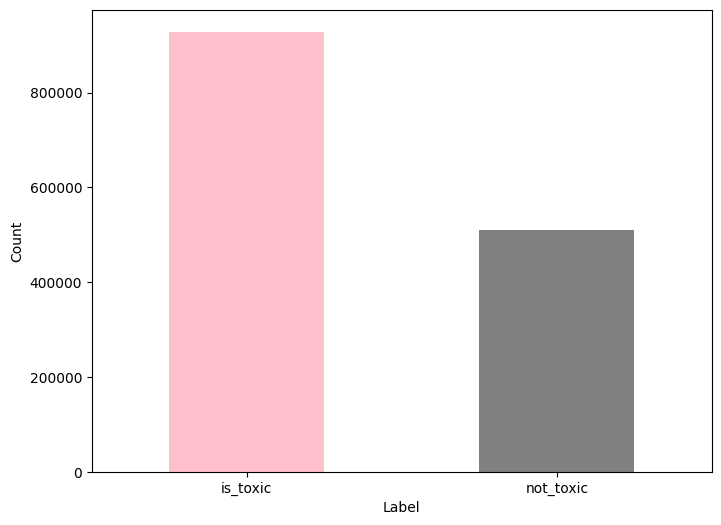

<Figure size 640x480 with 1 Axes>

In [0]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6)) 
bars = result_counts.plot(kind='bar', color=['pink', 'grey'])
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=0) 
plt.show()